# DeepChords

Multiheaded Root and Chord recognition model.

In [1]:
%matplotlib inline

# Setup autoreload for local modules, otherwise Jupyter caches modules
# on first load. Add new local modules here if necessary.
%load_ext autoreload
%autoreload 2
%aimport deepsamples, helpers, gen_chord_samples, gen_note_samples

# To use specific version
# %pip install --user tensorflow==2.1

Using TensorFlow backend.


# Generate Samples (Option 1)

Download dependencies and generate samples here. Alternatively you can download the pre-generated samples from the next step.

In [ ]:
# Onetime Setup
!rm -rf samples
%pip install midiutil
!sudo apt-get -y install sox fluidsynth
!wget --no-check-certificate https://muthanna.com/deepears/soundfont.sf2

In [ ]:
!mkdir -p samples
from gen_chord_samples import gen_chord_samples

In [71]:
!find samples | wc -l
!sox --i samples/A2-P0-minor-i0-110.000-S0-V0.29-noreject-attack.wav

10801
sox FAIL formats: can't open input file `samples/A2-P0-minor-i0-110.000-S0-V0.29-noreject-attack.wav': No such file or directory


# Download Samples (Option 2)

In [ ]:
!wget --no-check-certificate https://muthanna.com/deepears/chord-samples-v2.zip
!rm -rf samples
!unzip -q chord-samples-v2.zip
!ls -l samples/ | wc -l
!ls -l samples | head

# Config and Setup

In [2]:
import os
files = os.listdir("samples")
len(files)

10800

In [7]:
import numpy as np
from scipy.io import wavfile
from scipy import signal
import matplotlib
import matplotlib.pyplot as plt
from tensorflow.keras.utils import plot_model
from IPython import display

import helpers
from helpers import Config
from deepsamples import ChordSamples

Spectrogram for samples/D4-P51-major-i1-293.665-S0-V0.43-noreject-sustain.wav
(257, 67)


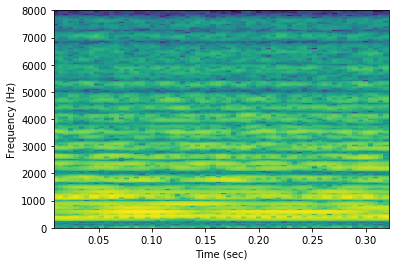

In [8]:
import os

config = Config(
    rows=256,
    cols = 64,
    s_nperseg = 256,
    s_nfft = 512,
    s_noverlap = 180,
    log_scale = True,
    clip_magnitude_quantile=0.25,
    resample = 16000)

helpers.spectrogram_from_file("samples/"+files[0], config=config)
None

Initializing DeepSamples:ChordSamples...
rows/cols: 256 64
Loading sample files...
Shuffling samples...
Generating spectrograms...
Normalizing data...
As4-P52-minor-i1-466.164-S0-V0.26-noreject-decay.wav
As
minor


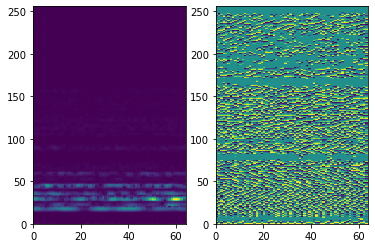

In [31]:
example = 4
samples = ChordSamples(num_samples=10, config=config)
samples.load()

print(samples.files[example])
print(samples.root_classes[np.argmax(samples.root_ys[example])])
print(samples.chord_classes[np.argmax(samples.chord_ys[example])])

plt.subplot(1, 2, 1)
plt.pcolormesh(samples.mags[example])
plt.subplot(1, 2, 2)
plt.pcolormesh(samples.phases[example])

loss
chord_answer_loss
root_answer_loss
chord_answer_accuracy
root_answer_accuracy
val_loss
val_chord_answer_loss
val_root_answer_loss
val_chord_answer_accuracy
val_root_answer_accuracy


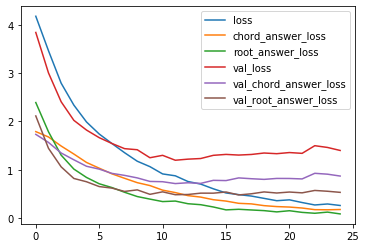

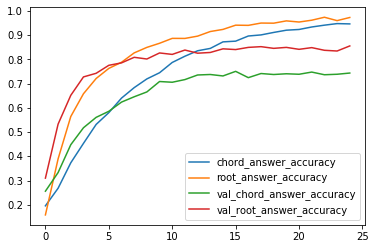

In [46]:
def plot_history(history):
  for k in history.history:
    vals = history.history[k]
    
    if k.endswith("loss"):
        plt.plot(vals, label=k)

  plt.legend()
  plt.figure()
    
  for k in history.history:
    vals = history.history[k]
    
    if k.endswith("accuracy"):
        plt.plot(vals, label=k)

  plt.legend()
  plt.show()

for k in history.history:
    print(k)

plot_history(history)

# DeepChords Models

In [11]:
import re
import sys
import os

import matplotlib.pyplot as plt
from scipy.io import wavfile
from scipy import signal
import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf
from tensorflow.keras import layers

## Multiheaded Model

This model has two inputs and two outputs. Magnitudes are run through a conv layer, and Phases through an RNN. Extracted features are sent to two dense layers, one emitting chords, and the other roots.

Initializing DeepSamples:ChordSamples...
rows/cols: 256 64
Model: "model_24"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
mags (InputLayer)               [(None, 256, 64)]    0                                            
__________________________________________________________________________________________________
phases (InputLayer)             [(None, 256, 64)]    0                                            
__________________________________________________________________________________________________
reshape_33 (Reshape)            (None, 256, 64, 1)   0           mags[0][0]                       
__________________________________________________________________________________________________
permute_17 (Permute)            (None, 64, 256)      0           phases[0][0]                     
________________________________

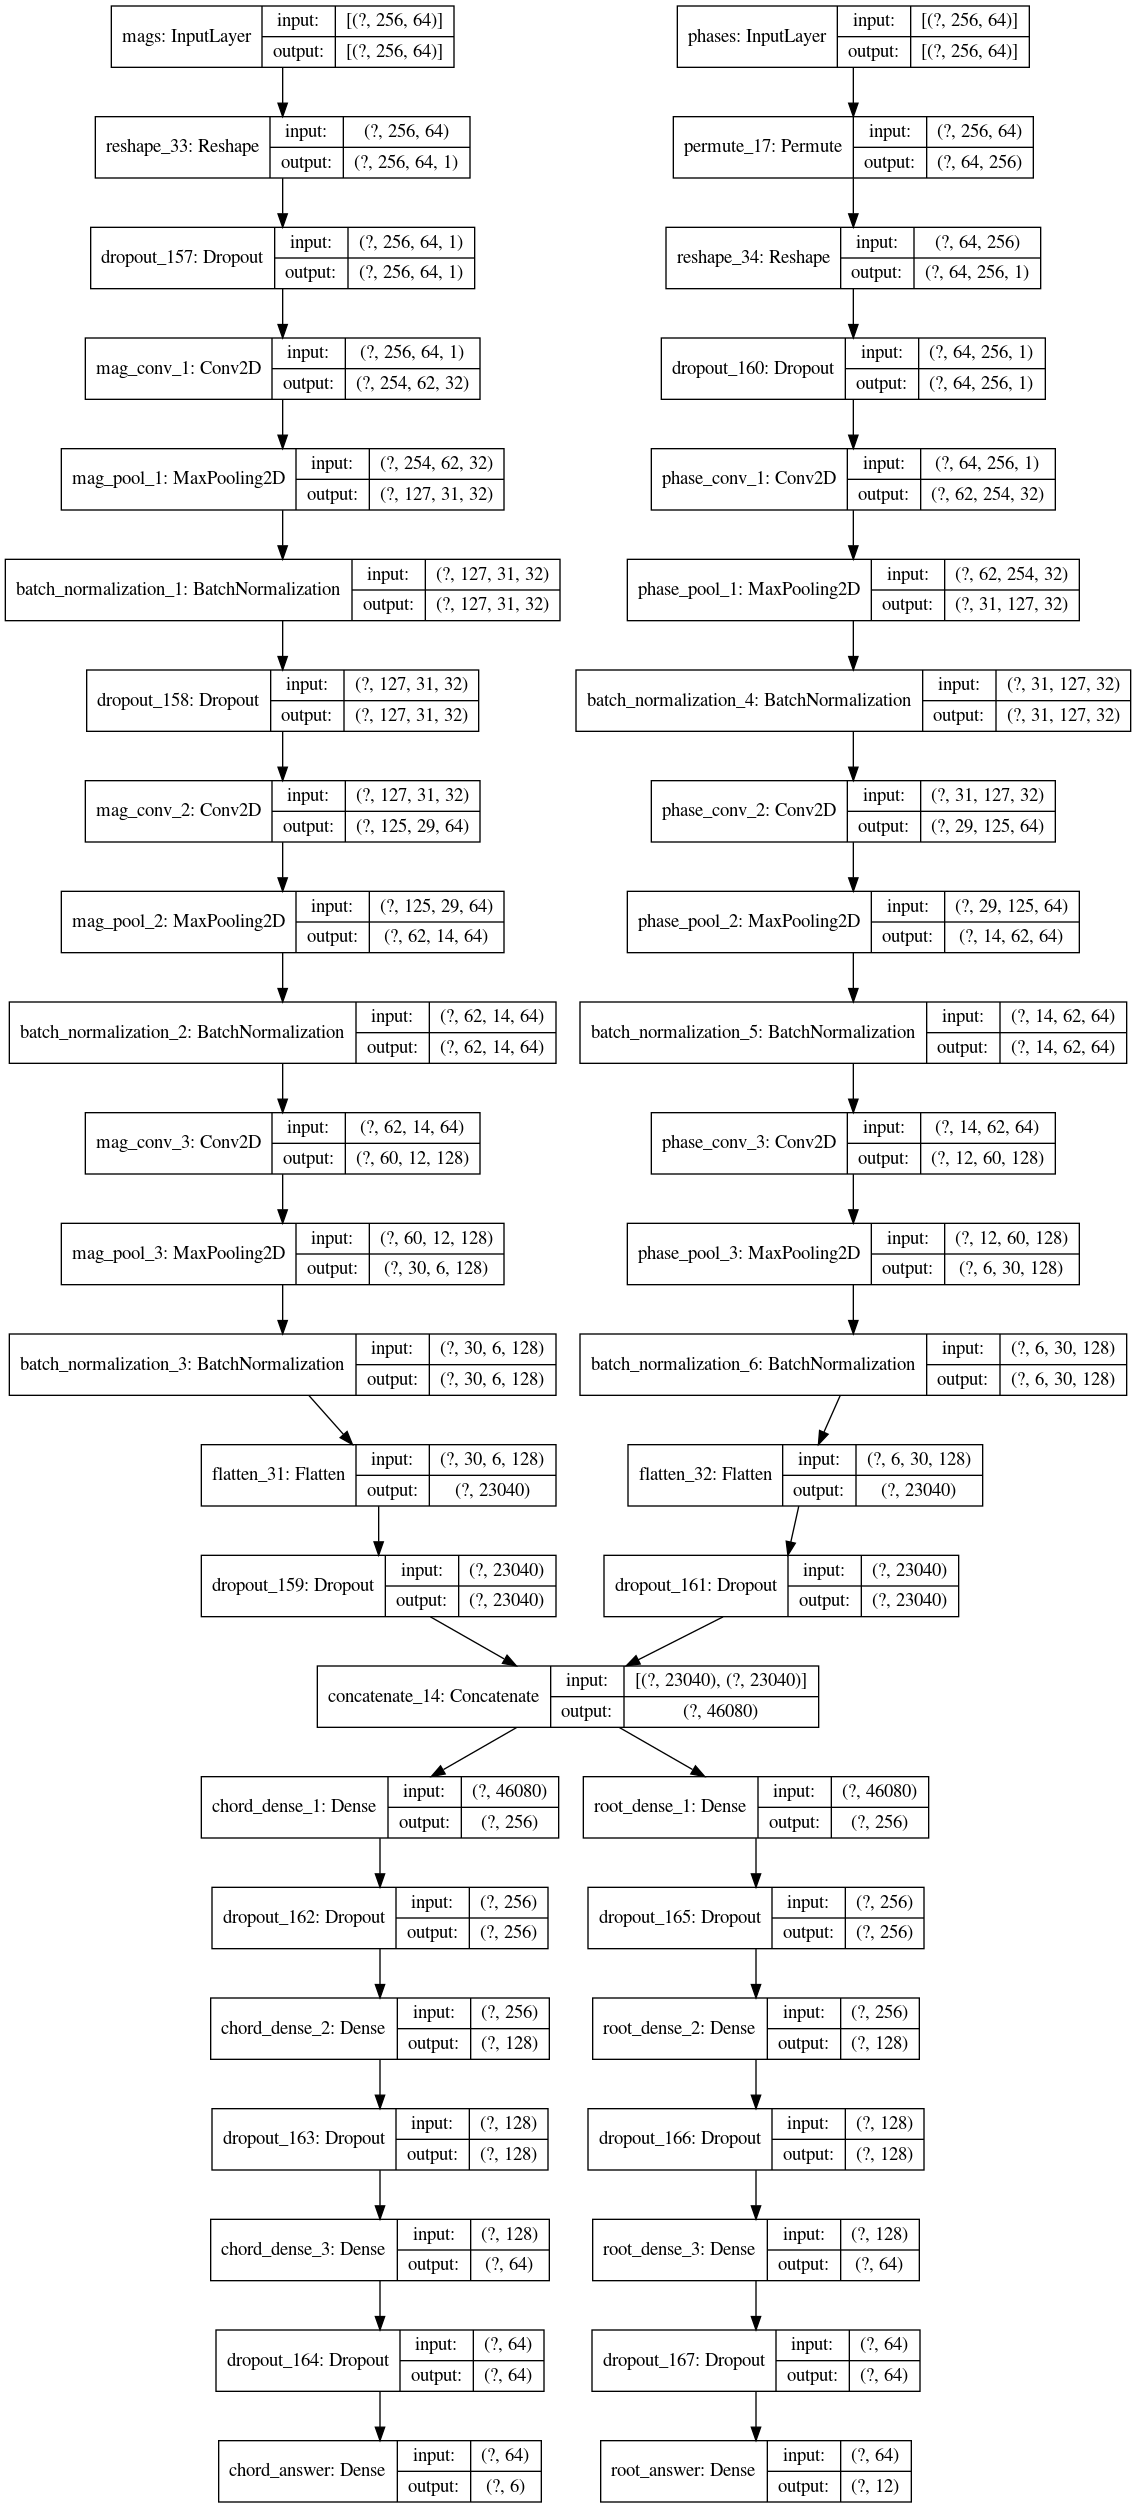

In [84]:
import tensorflow as tf
from tensorflow.keras import layers

dummy_samples = ChordSamples(num_samples=10, config=config)

rows = config.rows
cols = config.cols

mags_input = layers.Input(shape=(rows, cols), name='mags')
phases_input = layers.Input(shape=(rows, cols), name='phases')

mag_layers = layers.Reshape((rows, cols, 1))(mags_input)
mag_layers = layers.Dropout(0.2)(mag_layers)
mag_layers = layers.Conv2D(32, (3,3), activation='relu', name="mag_conv_1")(mag_layers)
mag_layers = layers.MaxPooling2D(pool_size=(2,2), name="mag_pool_1")(mag_layers)
mag_layers = layers.BatchNormalization()(mag_layers)
mag_layers = layers.Dropout(0.2)(mag_layers)
mag_layers = layers.Conv2D(64, (3,3), activation='relu', name="mag_conv_2")(mag_layers)
mag_layers = layers.MaxPooling2D(pool_size=(2,2), name="mag_pool_2")(mag_layers)
mag_layers = layers.BatchNormalization()(mag_layers)
mag_layers = layers.Conv2D(128, (3,3), activation='relu', name="mag_conv_3")(mag_layers)
mag_layers = layers.MaxPooling2D(pool_size=(2,2), name="mag_pool_3")(mag_layers)
mag_layers = layers.BatchNormalization()(mag_layers)
mag_layers = layers.Flatten()(mag_layers)
mag_layers = layers.Dropout(0.2)(mag_layers)

phase_layers = layers.Permute((2, 1))(phases_input)
phase_layers = layers.Reshape((cols, rows, 1))(phase_layers)
phase_layers = layers.Dropout(0.2)(phase_layers)
phase_layers = layers.Conv2D(32, (3,3), activation='relu', name="phase_conv_1")(phase_layers)
phase_layers = layers.MaxPooling2D(pool_size=(2,2), name="phase_pool_1")(phase_layers)
phase_layers = layers.BatchNormalization()(phase_layers)
phase_layers = layers.Conv2D(64, (3,3), activation='relu', name="phase_conv_2")(phase_layers)
phase_layers = layers.MaxPooling2D(pool_size=(2,2), name="phase_pool_2")(phase_layers)
phase_layers = layers.BatchNormalization()(phase_layers)
phase_layers = layers.Conv2D(128, (3,3), name="phase_conv_3", activation='relu')(phase_layers)
phase_layers = layers.MaxPooling2D(pool_size=(2,2), name="phase_pool_3")(phase_layers)
phase_layers = layers.BatchNormalization()(phase_layers)
phase_layers = layers.Flatten()(phase_layers)
phase_layers = layers.Dropout(0.2)(phase_layers)

concatenated = layers.concatenate([mag_layers, phase_layers])

chord_layers = layers.Dense(256, activation='relu', name='chord_dense_1')(concatenated)
chord_layers = layers.Dropout(0.2)(chord_layers)
chord_layers = layers.Dense(128, activation='relu', name='chord_dense_2')(chord_layers)
chord_layers = layers.Dropout(0.2)(chord_layers)
chord_layers = layers.Dense(64, activation='relu', name='chord_dense_3')(chord_layers)
chord_layers = layers.Dropout(0.2)(chord_layers)
chord_answer = layers.Dense(len(dummy_samples.chord_classes), activation='softmax', name='chord_answer')(chord_layers)

root_layers = layers.Dense(256, activation='relu', name='root_dense_1')(concatenated)
root_layers = layers.Dropout(0.2)(root_layers)
root_layers = layers.Dense(128, activation='relu', name='root_dense_2')(root_layers)
root_layers = layers.Dropout(0.2)(root_layers)
root_layers = layers.Dense(64, activation='relu', name='root_dense_3')(root_layers)
root_layers = layers.Dropout(0.2)(root_layers)
root_answer = layers.Dense(len(dummy_samples.root_classes), activation='softmax', name='root_answer')(root_layers)

model = tf.keras.models.Model([mags_input, phases_input], [chord_answer, root_answer])
model.summary()

optimizer = tf.keras.optimizers.Adam(amsgrad=True)
model.compile(loss=['categorical_crossentropy', 'categorical_crossentropy'], optimizer=optimizer, metrics=['accuracy'])

plot_model(model, to_file="model.png", show_shapes=True, show_layer_names=True, )
display.display(display.Image("model.png"))

In [59]:
total_samples = 7000
training_samples = 6000

prod_samples = ChordSamples(num_samples=total_samples, config=config)
prod_samples.load()

Initializing DeepSamples:ChordSamples...
rows/cols: 256 64
Loading sample files...
Shuffling samples...
Generating spectrograms...
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
Normalizing data...


In [ ]:
history = model.fit([prod_samples.mags[:training_samples], prod_samples.phases[:training_samples]], [prod_samples.chord_ys[:training_samples], prod_samples.root_ys[:training_samples]], epochs=25, batch_size=64, validation_split=0.2)
plot_history(history)

Train on 4800 samples, validate on 1200 samples
Epoch 1/25
2176/4800 [============>.................] - ETA: 8s - loss: 5.9597 - chord_answer_loss: 2.9187 - root_answer_loss: 3.0410 - chord_answer_accuracy: 0.1903 - root_answer_accuracy: 0.1806

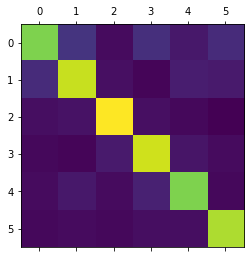

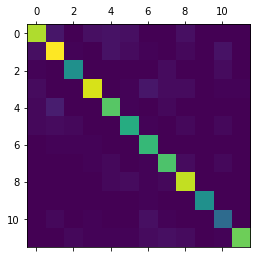

In [69]:
predictions = model.predict([prod_samples.mags[training_samples:], prod_samples.phases[training_samples:]])
chord_predictions = np.argmax(predictions[0], axis=-1)
root_predictions = np.argmax(predictions[1], axis=-1)

chord_labels = np.argmax(prod_samples.chord_ys[training_samples:], axis=1)
root_labels = np.argmax(prod_samples.root_ys[training_samples:], axis=1)
plt.matshow(tf.math.confusion_matrix(chord_predictions, chord_labels))
plt.matshow(tf.math.confusion_matrix(root_predictions, root_labels))

(1, 254, 62, 32)


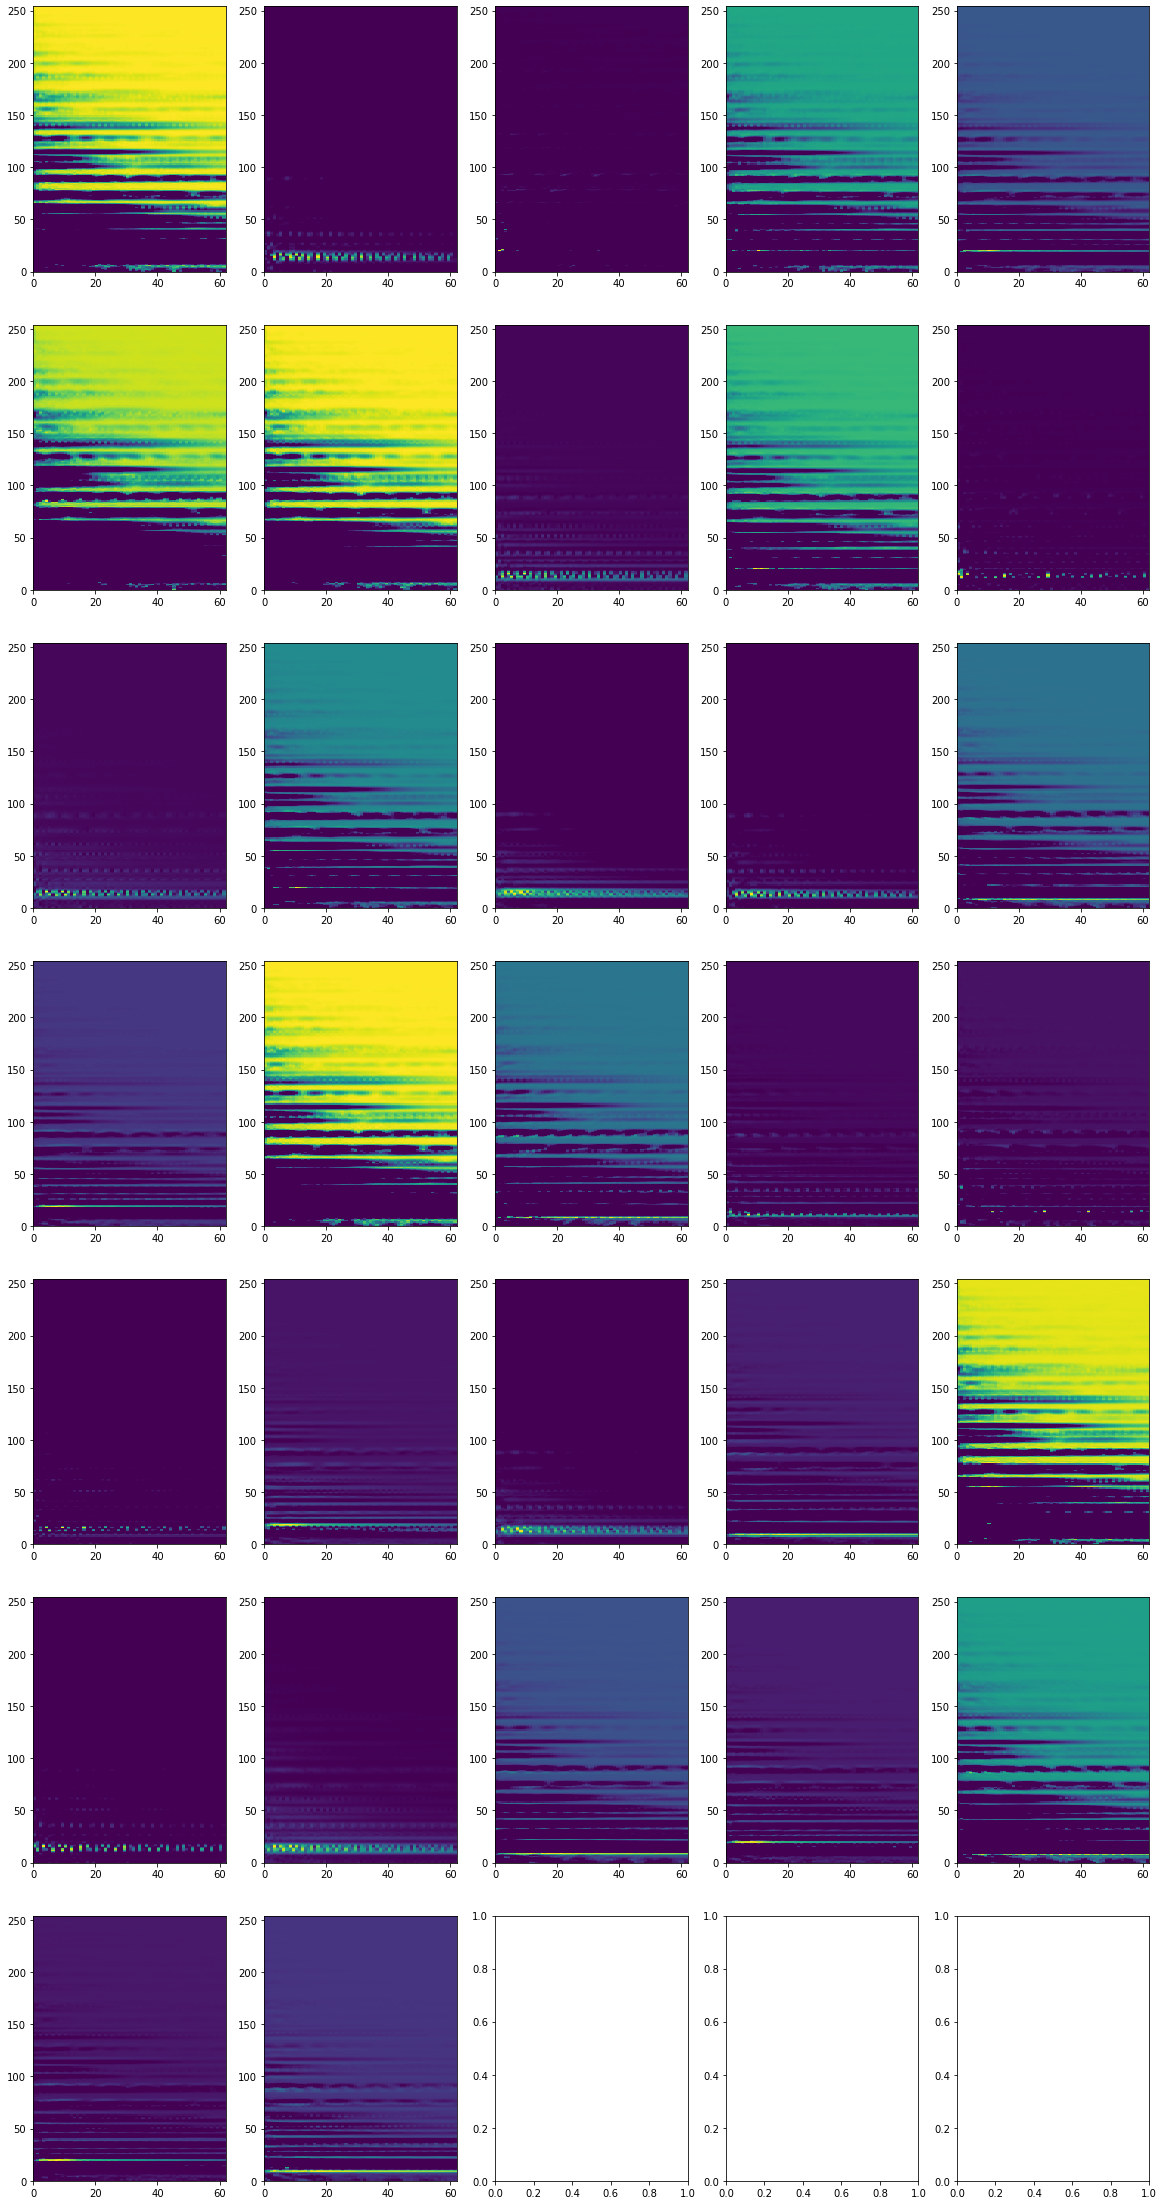

In [75]:
def visualize_filters(layer_num, count, x, model=model):
  layer = model.get_layer(index=layer_num)
  layer_output=layer.output
  
  intermediate_model=tf.keras.models.Model(inputs=model.inputs,outputs=layer_output)
  intermediate_prediction=intermediate_model.predict(x)

  col_size=5
  row_size=int(count / col_size) + 1
  
  print(np.shape(intermediate_prediction))
  fig,ax=plt.subplots(row_size,col_size,figsize=(20,40))

  img_index=0
  row=0
  col=0
  while img_index < count:
    ax[row][col].pcolormesh(intermediate_prediction[0, :, :, img_index])
    img_index=img_index+1
    col += 1
    if col >= col_size:
      col = 0
      row +=1
    if img_index > count: break

visualize_filters(6, 32, x=[prod_samples.mags[0].reshape(1, rows, cols), prod_samples.phases[0].reshape(1, rows, cols)])

mags: 64 (1, 256, 64)
phases: 64 (1, 256, 64)
reshape_28: 1 (1, 256, 64, 1)
permute_15: 256 (1, 64, 256)
dropout_134: 1 (1, 256, 64, 1)
reshape_29: 1 (1, 64, 256, 1)
conv2d_81: 32 (1, 254, 62, 32)
dropout_137: 1 (1, 64, 256, 1)
max_pooling2d_78: 32 (1, 127, 31, 32)
conv2d_84: 32 (1, 62, 254, 32)
dropout_135: 32 (1, 127, 31, 32)
max_pooling2d_81: 32 (1, 31, 127, 32)


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: divide by zero encountered in log


conv2d_82: 64 (1, 125, 29, 64)
conv2d_85: 64 (1, 29, 125, 64)
max_pooling2d_79: 64 (1, 62, 14, 64)
max_pooling2d_82: 64 (1, 14, 62, 64)
conv2d_83: 128 (1, 60, 12, 128)
conv2d_86: 128 (1, 12, 60, 128)
max_pooling2d_80: 128 (1, 30, 6, 128)
max_pooling2d_83: 128 (1, 6, 30, 128)
flatten_27: 23040 (1, 23040)
flatten_28: 23040 (1, 23040)
dropout_136: 23040 (1, 23040)
dropout_138: 23040 (1, 23040)
concatenate_12: 46080 (1, 46080)
chord_dense_1: 256 (1, 256)
root_dense_1: 256 (1, 256)
dropout_139: 256 (1, 256)
dropout_142: 256 (1, 256)
chord_dense_2: 128 (1, 128)
root_dense_2: 128 (1, 128)
dropout_140: 128 (1, 128)
dropout_143: 128 (1, 128)
chord_dense_3: 64 (1, 64)
root_dense_3: 64 (1, 64)
dropout_141: 64 (1, 64)
dropout_144: 64 (1, 64)
chord_answer: 6 (1, 6)
root_answer: 12 (1, 12)


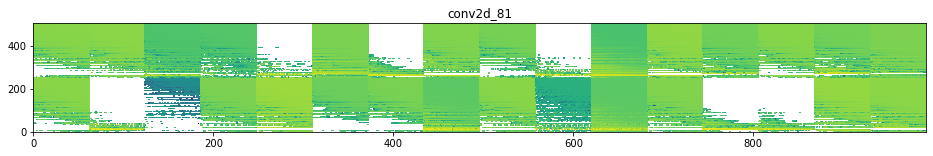

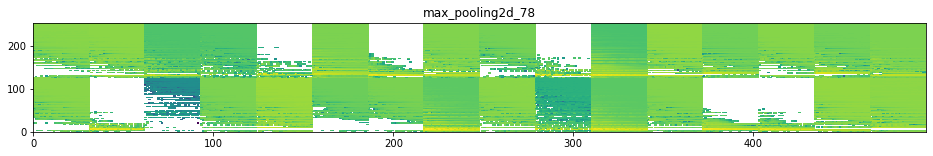

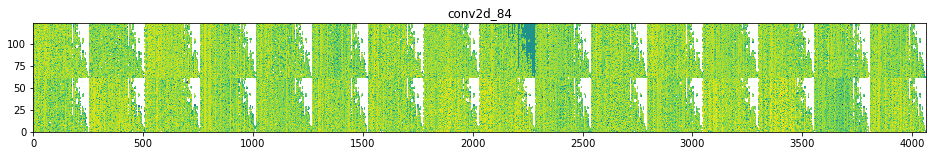

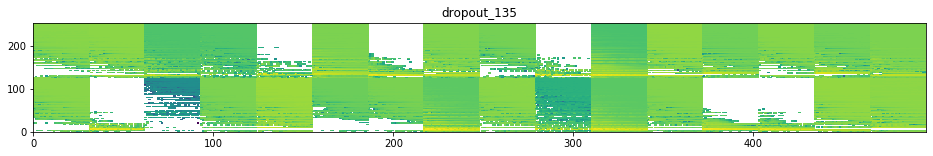

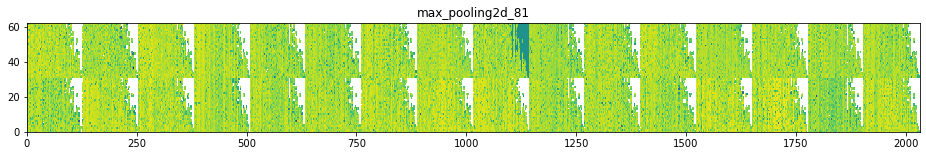

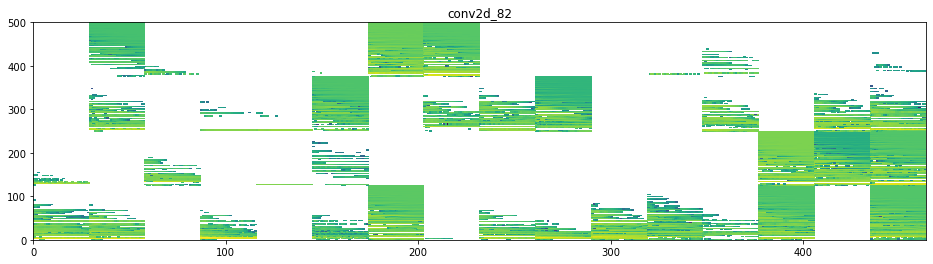

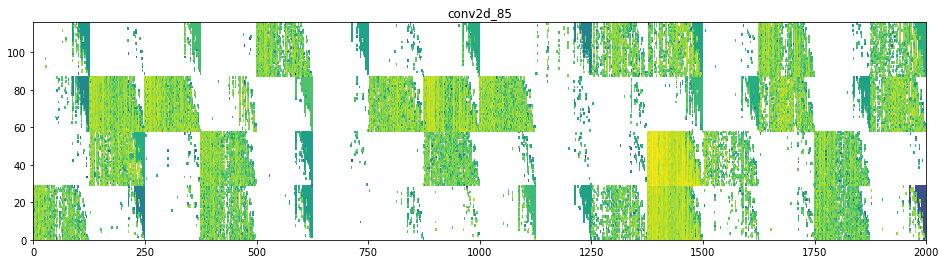

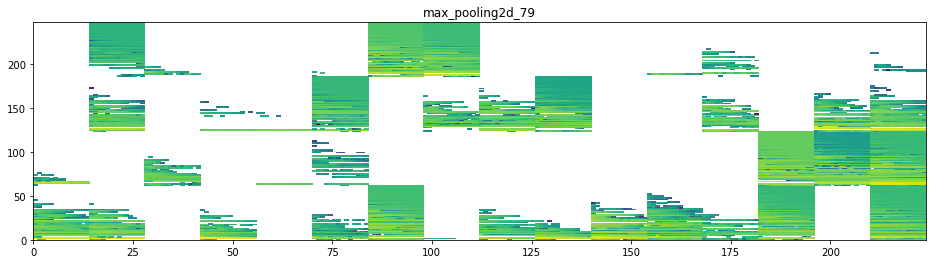

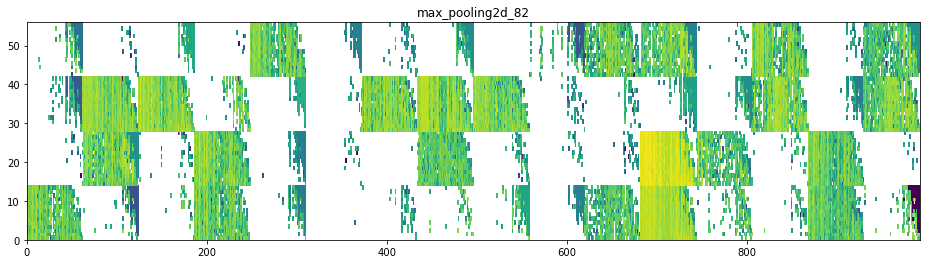

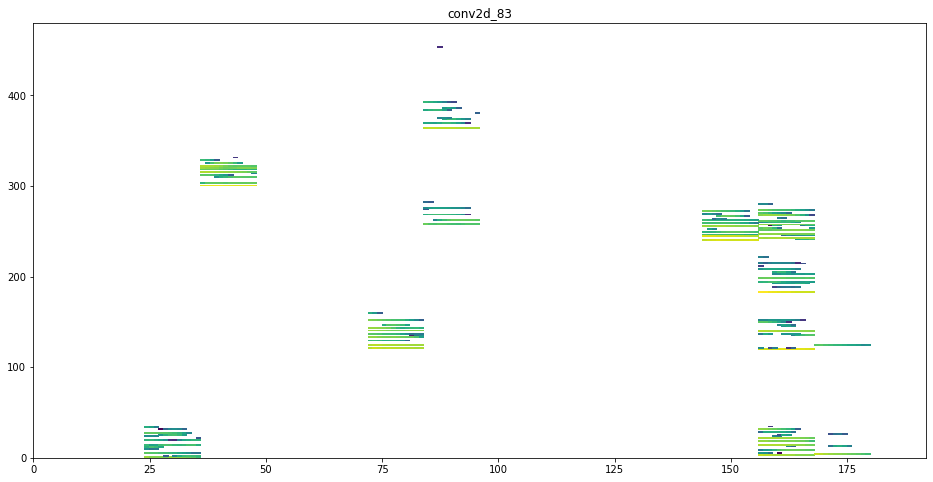

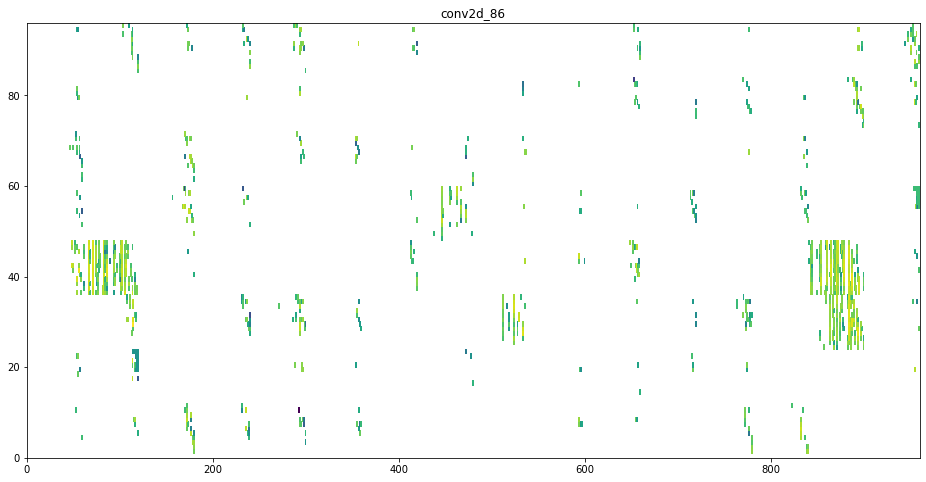

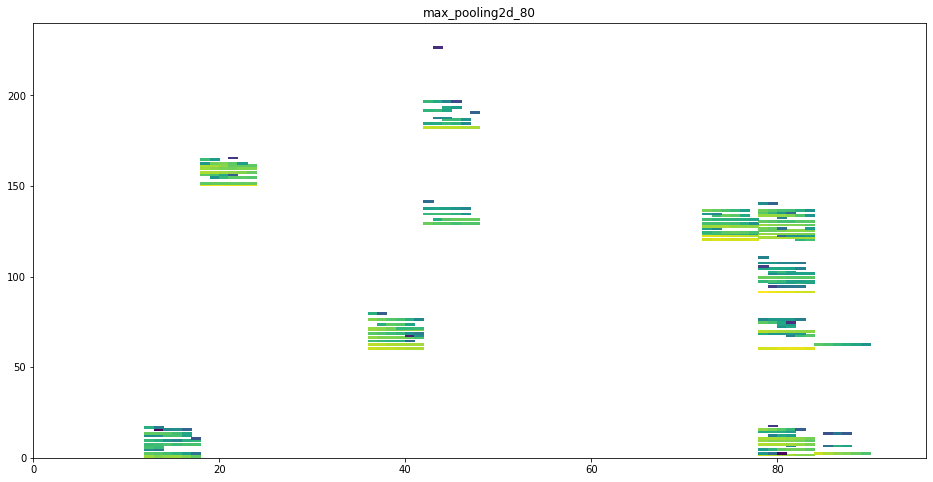

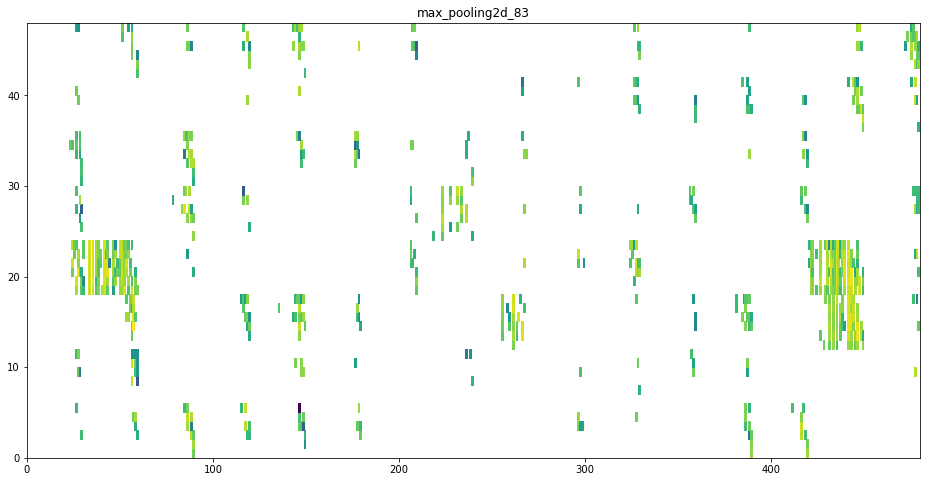

In [81]:
from keras import models

layer_outputs = [layer.output for layer in model.layers]
activation_model = tf.compat.v1.keras.Model(inputs=model.inputs, outputs=layer_outputs)

activations = activation_model.predict([prod_samples.mags[0].reshape(1, rows, cols), prod_samples.phases[0].reshape(1, rows, cols)]) 

layer_names = []
for layer in model.layers:
  layer_names.append(layer.name)

images_per_row = 16

for layer_name, layer_activation in zip(layer_names, activations):
  n_features = layer_activation.shape[-1]
  n_cols = n_features // images_per_row
  print("%s:" % layer_name, n_features, layer_activation.shape)
  if len(layer_activation.shape) < 4:
    continue

  if n_cols == 0:
    continue

  col_size = layer_activation.shape[1]
  row_size = layer_activation.shape[2]

  display_grid = np.zeros((col_size * n_cols, images_per_row * row_size))

  for col in range(n_cols):
      for row in range(images_per_row):
          channel_image = np.log(layer_activation[0, :, :, col * images_per_row + row])
          display_grid[col * col_size : (col + 1) * col_size, row * row_size : (row + 1) * row_size] = channel_image
    
  col_scale =1. / col_size
  row_scale =1. / row_size

  plt.figure(figsize=(row_scale * display_grid.shape[1], col_scale * display_grid.shape[0]))
  
  plt.title(layer_name)
  plt.grid(False)
  plt.pcolormesh(display_grid)

# Save Models

In [ ]:
# Auth this runtime to GCP (once only)
from google.colab import auth
auth.authenticate_user()

In [ ]:
deepears.model.save("deepears_pitch_model.h5")

In [ ]:
!gsutil -m cp -a public-read *.h5 gs://muthanna.com/deepears

Copying file://deepears_root_model.h5 [Content-Type=application/octet-stream]...
Copying file://deepears_chord_model.h5 [Content-Type=application/octet-stream]...
-
Operation completed over 2 objects/331.0 MiB.                                    


# Live Test

In [ ]:
fs, data = wavfile.read('sweetchild-8bit.wav')
sample_len = int(8000 * 0.33) # 0.33ms slice of 8khz audio
num_samples = int(len(data) / sample_len)
remainder = len(data) % sample_len

samples = np.reshape(data[0:len(data) - remainder], (num_samples, sample_len))

In [ ]:
for i in range(0, num_samples):
  f, t, Sxx = signal.spectrogram(samples[i], fs, window=('hann'), nperseg=64, nfft=128, noverlap=16, mode='magnitude')
  Sxx = Sxx.reshape(1, 65, 54,1)
  root_class = deepears.root_model.predict_classes(Sxx)
  chord_class = deepears.chord_model.predict_classes(Sxx)
  
  chord = deepears.get_chord_classes()[int(chord_class)]
  root = deepears.get_root_classes()[int(root_class)]
  print(i * 0.33, "seconds:", root, chord)


0.0 seconds: Cs min7
0.33 seconds: Cs dom7
0.66 seconds: D dom7
0.99 seconds: As dom7
1.32 seconds: D dom7
1.6500000000000001 seconds: Fs dom7
1.98 seconds: Cs dom7
2.31 seconds: Fs min7
2.64 seconds: E maj7
2.97 seconds: D dom7
3.3000000000000003 seconds: F major
3.6300000000000003 seconds: D maj7
3.96 seconds: Cs min7
4.29 seconds: Fs sus2
4.62 seconds: Ds dom7
4.95 seconds: Ds dom7
5.28 seconds: Ds min7
5.61 seconds: Fs dom7
5.94 seconds: D dom7
6.2700000000000005 seconds: Cs dom7
6.6000000000000005 seconds: Cs dom7
6.930000000000001 seconds: D min7
7.260000000000001 seconds: Cs dom7
7.590000000000001 seconds: D dom7
7.92 seconds: Fs dom7
8.25 seconds: D dom7
8.58 seconds: G min7
8.91 seconds: Fs minor
9.24 seconds: D dom7
9.57 seconds: D dom7
9.9 seconds: B min7
10.23 seconds: Ds dom7
10.56 seconds: Fs dom7
10.89 seconds: Fs dom7
11.22 seconds: Cs dom7
11.55 seconds: C dom7
11.88 seconds: B maj7
12.21 seconds: Cs dom7
12.540000000000001 seconds: As dom7
12.870000000000001 seconds: 